Plotting Bad Bump Test (through noise at BV = -2V) for HPK31_1


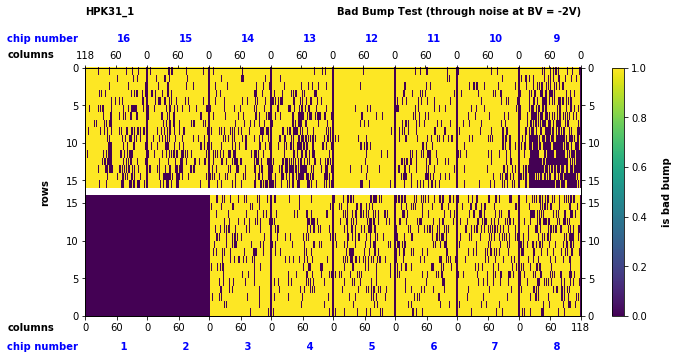

Note that plot has not been saved.
Plotting Bad Bump Test (through noise at BV = -2V) for HPK31_1


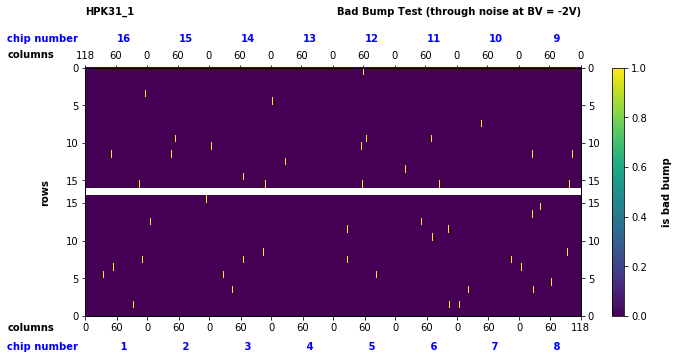

Note that plot has not been saved.
Plotting Identified abnormal pixel noise (at BV = -2V) for HPK31_1


In [ ]:
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc
from scipy.special import erf
import matplotlib.cm as cm
import matplotlib.backends.backend_pdf as pltpdf
#import seaborn as sns
import csv
import math
#sys.path.append('myScripts/') #python 2.7 ?
#from mpa_configurations import * # python 2.7 ?
from mpa_configurations import *
import os.path
import glob
import re

meansfT = []
meansdT = []
meansfC = []
meansdC = []

def errorf(x, *p):
    a, mu, sigma = p
    return 0.5*a*(1.0+erf((x-mu)/sigma))
def line(x, *p):
    g, offset = p
    return  np.array(x) *g + offset
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
def errorfc(x, *p):
    a, mu, sigma = p
    return a*0.5*erfc((x-mu)/sigma)
np.set_printoptions(threshold=sys.maxsize)

def loadValuesFromCSV(csvfilename):
    #print(csvfilename)
    #valuedict = dict()
    values = []
    with open(csvfilename, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            if row[0] == '':
                continue
            pixedid = int(row[0])
            value = float(row[1])
            #valuedict[pixedid] = value
            values.append(value)
    #return valuedict
    return values

#item 0 is pixel identifier
def loadSCurvesFromCSV(csvfilename):
    #print(csvfilename)
    #scurvedict = dict()
    scurves = []
    #pixels = []
    start = 0
    stop = 256
    step = 1
    with open(csvfilename, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            scurve = []
            if row[0] == '':
                start = int(row[1])
                stop = int(row[-1])
                step = int(row[2])-int(row[1])
                continue
            pixedid = int(row[0])
            for i in range(1,len(row)):
                scurve.append(int(row[i]))
            #scurve = row[1:]
            #pixels.append(pixedid)
            scurves.append(scurve)
            #scurvedict[pixedid] = scurve
    #return scurvedict,start,stop,step
    return scurves,start,stop,step

def extract_scurve_differentiate(s_curve,s_type="THR",n_pulse=1000,nominal_DAC=-1,start=0,stop=256):
    if nominal_DAC == -1:
        if s_type=="THR":
            nominal_DAC = 85
        elif s_type=="CAL":
            nominal_DAC = 15
    rms  = -1
    scurve = np.array(s_curve)
    scurve = np.delete(scurve, -1)#last entry always a 0
    step = min(int((stop-start)/len(scurve)),1)
    DACvals = np.array(range(start,stop,step))
    if len(DACvals) != len(scurve):
        print("len(scurve) "+str(len(scurve))+", len(DACvals) "+str(len(DACvals)))
        return -1,-1,False
    differentiated = np.diff(scurve)/np.diff(DACvals)
    minmaxs = []
    if s_type == "THR":
        minmaxs = (np.diff(np.sign(np.diff(differentiated))) > 0).nonzero()[0] + 1 # local min
    elif s_type == "CAL":
        minmaxs = (np.diff(np.sign(np.diff(differentiated))) < 0).nonzero()[0] + 1 # local max

    scurvesvals = []
    for i in minmaxs: scurvesvals.append(scurve[i])
    meanpos = 0
    if len(scurvesvals)>0:
        meanpos = min(range(len(scurvesvals)), key=lambda i: abs(scurvesvals[i]-(n_pulse/2.)))
    else:
        #print("No s curve found.")
        return -1,-1,False
    if (minmaxs[meanpos] <= (start +1)) or (minmaxs[meanpos] >= (stop -1)):#no good position to extract 
        return -1,-1,False
    if scurve[meanpos]<0 or scurve[meanpos]>n_pulse:
        return -1,-1,False
    findmeanx = [DACvals[minmaxs[meanpos]-1],DACvals[minmaxs[meanpos]],DACvals[minmaxs[meanpos]+1]]
    findmeany = [scurve[minmaxs[meanpos]-1],scurve[minmaxs[meanpos]],scurve[minmaxs[meanpos]+1]]
    linefit = np.polyfit(findmeanx,findmeany,1)
    if linefit[0] == 0:
        print("Fit failed.")
        return -1,-1,False
    truemean = ((n_pulse/2)-linefit[1])/linefit[0]
    closestpos_truemean = min(range(len(DACvals)), key=lambda i: abs(DACvals[i]-truemean))
    sigma1 = False
    #sigma1val = 0.21
    sigma1val = 0.37
    idx1_a = closestpos_truemean
    idx1_b = closestpos_truemean
    true1sigmaplus  = -1
    true1sigmaminus = -1
    while (not sigma1) and (idx1_a>0) and idx1_a < (len(DACvals)-2):#2 sigma
        if abs(differentiated[idx1_a])<=sigma1val*abs(differentiated[closestpos_truemean]):
            sigma1 = True
            break
        idx1_a += 1
    sigma1 = False
    if (idx1_a>0) and (idx1_a<(len(DACvals)-1)) and (abs(abs(differentiated[idx1_a-1])-sigma1val*n_pulse)<abs(abs(differentiated[idx1_a])-sigma1val*n_pulse)): idx1_a -= 1
    while (not sigma1) and idx1_b > 0 and idx1_b < (len(DACvals)-2):#2 sigma
        if abs(differentiated[idx1_b])<=sigma1val*abs(differentiated[closestpos_truemean]):
            sigma1 = True
            break
        idx1_b -= 1
    if (idx1_b>0) and (idx1_b<(len(DACvals)-1)) and (abs(abs(differentiated[idx1_b+1])-sigma1val*n_pulse)<abs(abs(differentiated[idx1_b])-sigma1val*n_pulse)): idx1_b -= 1
    """
    findmeanx = [DACvals[idx1_a-1],DACvals[idx1_a],DACvals[idx1_a+1]]
    findmeany = [scurve[idx1_a-1],scurve[idx1_a],scurve[idx1_a+1]]
    linefit = np.polyfit(findmeanx,findmeany,1)
    if linefit[0] != 0:
        if s_type == "THR":
            true1sigmaplus = (n_pulse*0.0786496-linefit[1])/linefit[0]
        if s_type == "CAL":
            true1sigmaplus = (n_pulse*0.9213504-linefit[1])/linefit[0]
    findmeanx = [DACvals[idx1_b-1],DACvals[idx1_b],DACvals[idx1_b+1]]
    findmeany = [scurve[idx1_b-1],scurve[idx1_b],scurve[idx1_b+1]]
    linefit = np.polyfit(findmeanx,findmeany,1)
    if linefit[0] != 0:
        if s_type == "THR":
            true1sigmaminus = (n_pulse*0.9213504-linefit[1])/linefit[0]
        if s_type == "CAL":
            true1sigmaminus = (n_pulse*0.0786496-linefit[1])/linefit[0]
    """
    sigma2 = False
    #sigma2val = 0.01
    sigma2val = 0.018
    idx2_a  = idx1_a
    idx2_b  = idx1_b
    true2sigmaplus  = -1
    true2sigmaminus = -1
    while (not sigma2) and (idx2_a>0) and idx2_a < (len(DACvals)-2):#2 sigma
        if abs(differentiated[idx2_a])<=sigma2val*abs(differentiated[closestpos_truemean]):
            sigma2 = True
            break
        idx2_a += 1
    sigma2 = False
    if (idx2_a>0) and (idx2_a<(len(DACvals)-1)) and (abs(abs(differentiated[idx2_a-1])-sigma2val*n_pulse)<abs(abs(differentiated[idx2_a])-sigma2val*n_pulse)): idx2_a -= 1
    while (not sigma2) and idx2_b > 0 and idx2_b < (len(DACvals)-2):#2 sigma
        if abs(differentiated[idx2_b])<=sigma2val*abs(differentiated[closestpos_truemean]):
            sigma2 = True
            break
        idx2_b -= 1
    if (idx2_b>0) and (idx2_b<(len(DACvals)-1)) and (abs(abs(differentiated[idx2_b+1])-sigma2val*n_pulse)<abs(abs(differentiated[idx2_b])-sigma2val*n_pulse)): idx2_b -= 1
    """
    findmeanx = [DACvals[idx2_a-1],DACvals[idx2_a],DACvals[idx2_a+1]]
    findmeany = [scurve[idx2_a-1],scurve[idx2_a],scurve[idx2_a+1]]
    linefit = np.polyfit(findmeanx,findmeany,1)
    if linefit[0] != 0:
        if s_type == "THR":
            true2sigmaplus = (n_pulse*0.0023388-linefit[1])/linefit[0]
        if s_type == "CAL":
            true2sigmaplus = (n_pulse*0.9976611-linefit[1])/linefit[0]
    findmeanx = [DACvals[idx2_b-1],DACvals[idx2_b],DACvals[idx2_b+1]]
    findmeany = [scurve[idx2_b-1],scurve[idx2_b],scurve[idx2_b+1]]
    linefit = np.polyfit(findmeanx,findmeany,1)
    if linefit[0] != 0:
        if s_type == "THR":
            true2sigmaminus = (n_pulse*0.9976611-linefit[1])/linefit[0]
        if s_type == "CAL":
            true2sigmaminus = (n_pulse*0.0023388-linefit[1])/linefit[0]
    """
    #print(idx1_a,true1sigmaplus,"   ",idx1_b,true1sigmaminus, " --- ", idx2_a,true2sigmaplus,"   ",idx2_b,true2sigmaminus)
    #print((true2sigmaplus-true2sigmaminus)/4,(true1sigmaplus-true1sigmaminus)/2)
    return truemean,(DACvals[idx1_a]-DACvals[idx1_b])/2.,True


def extract_scurve(s_curve,s_type="THR",n_pulse=1000,nominal_DAC=-1,start=0,stop=256):
    if nominal_DAC == -1:
        if s_type=="THR":
            nominal_DAC = 85
        elif s_type=="CAL":
            nominal_DAC = 15
    mean = -1
    rms  = -1
    scurve = np.array(s_curve)
    fitsuccess = True;
    #print (s_type,n_pulse,nominal_DAC,start,stop)
    try:
        if s_type == "THR":
            start_DAC = np.argmax(scurve)+10
            while start_DAC <  (stop-start):
                if math.fabs(scurve[start_DAC] - n_pulse) < math.sqrt(n_pulse):
                    break
                start_DAC += 1
            if start_DAC >= stop-start-1:
                start_DAC = min(np.argmax(scurve)+10,stop-start-5)    
                #print("Fit Range (",start_DAC," to ", (stop-start), ") with initial parameters ", [n_pulse, nominal_DAC, 2],"for pixel",pixel)
                #print("A",range(start_DAC, (stop-start)))
                #print("B",scurve)
            par, cov = curve_fit(errorfc, range(start_DAC, (stop-start)), scurve[start_DAC + 1 :(stop-start) + 1], p0= [n_pulse, (start_DAC+(stop-start))/2, 2])
            #print("Paramters from fit ",par)
            #print("Covariance ", cov)
            mean = par[1]
            rms  = par[2]
        elif s_type == "CAL":
            start_DAC = 0
            #print("Fit Range (",start_DAC," to ", (stop-start), ") with initial parameters ", [n_pulse, nominal_DAC, 2])
            par, cov = curve_fit(errorf,  range(start_DAC, (stop-start)), scurve[start_DAC + 1 :(stop-start) + 1], p0= [n_pulse, nominal_DAC, 2])
            #print("Paramters from fit ",par)
            #print("Covariance ", cov)
            mean = par[1]
            rms  = par[2]
    except RuntimeError or TypeError:
        fitsuccess = False
        #print("Fit fails for input data")
        #print(s_curve)

    return mean,rms,fitsuccess

#def extract_meanrms_fromSCurves(scurves,s_type="THR",n_pulse=1000,nominal_DAC=-1,start=0,stop=256):
#    meandict = dict()
#    rmsdict  = dict()
#    for pixel in scurves:
#        mean,rms,fit = extract_scurve(s_curve=scurves[pixel],s_type=s_type,n_pulse=n_pulse,nominal_DAC=nominal_DAC,start=start,stop=stop)
#        meandict[pixel] = mean
#        rmsdict[ pixel] = rms
#    return meandict,rmsdict

#method using fit is default right now
def extract_meanrms_fromSCurves(scurves,s_type="THR",n_pulse=1000,nominal_DAC=-1,start=0,stop=256):
    means = []
    rmss = []
    for s_curve in scurves:
        mean,rms,fit = extract_scurve(s_curve=s_curve,s_type=s_type,n_pulse=n_pulse,nominal_DAC=nominal_DAC,start=start,stop=stop)
        means.append(mean)
        rmss.append(rms)
    return means,rmss

"""
#test function to compare default (fit) with differentiation
def extract_meanrms_fromSCurves(scurves,s_type="THR",n_pulse=1000,nominal_DAC=-1,start=0,stop=256):
    means = []
    rmss = []
    #print("TTT",len(scurves),type(scurves))
    #print("TTTT",scurves)
    for s_curve in scurves:
        #print("SSSS",s_curve)
        meanf,rmsf,fitf = extract_scurve(s_curve=s_curve,s_type=s_type,n_pulse=n_pulse,nominal_DAC=nominal_DAC,start=start,stop=stop)
        meand,rmsd,fitd = extract_scurve_differentiate(s_curve=s_curve,s_type=s_type,n_pulse=n_pulse,nominal_DAC=nominal_DAC,start=start,stop=stop)
        #print("1")
        if s_type == "THR":
            meansfT.append(meanf)
            meansdT.append(meand)
        elif s_type == "CAL":
            meansfC.append(meanf)
            meansdC.append(meand)
        mean,rms,fit = extract_scurve(s_curve=s_curve,s_type=s_type,n_pulse=n_pulse,nominal_DAC=nominal_DAC,start=start,stop=stop)
        means.append(mean)
        rmss.append(rms)
    return means,rmss
"""

def getRowOfMPAinMaPSAs(mpa,row):#this y
    #returns row id in a 2D map of a full MaPSA
    if mpa <  8: return row #keep this notation for more intuition
    if mpa >= 8: return (conf.nrowsnom+1)*2-1 - row-1 #keep this notation for more intuition
    ###if mpa <  8: return     mpa  * (conf.nrowsnom+1) + (row+1) - 1 #keep this notation for more intuition
    ###if mpa >= 8: return (16-mpa) * (conf.nrowsnom+1) - (row+1) - 1 #keep this notation for more intuition
    return -1 #haha

def getColOfMPAinMaPSAs(mpa,col):
    #returns row id in a 2D map of a full MaPSA
    ###if mpa <  8: return col #keep this notation for more intuition
    ###if mpa >= 8: return ((conf.ncolsnom+2)*2) - col #keep this notation for more intuition
    #double chip spacing due to bad graphics
    #if mpa <  8: return     mpa  * (conf.ncolsnom+2) + col #keep this notation for more intuition
    #if mpa >= 8: return (16-mpa) * (conf.ncolsnom+2)-2 - col-1 #keep this notation for more intuition - the last chip has not an empty column
    #nominal
    if mpa <  8: return     mpa  * (conf.ncolsnom+1) + col #keep this notation for more intuition
    if mpa >= 8: return (16-mpa) * (conf.ncolsnom+1)-1 - col-1 #keep this notation for more intuition - the last chip has not an empty column
    return -1 #haha

def MakeModulePlot(arrays_of_data= [ [] ], row = [],col = [],nfig=5,hmin=-1,hmax=-1, percentile = 0.05, plotAverage = True, identifier="", xlabel="columns", data_label="", test_label="", israw = False, filename="", show_plot=True, save_plot=True):
    #print("MakeModulePlot(",arrays_of_data,row,col,nfig,hmin,hmax,percentile,plotAverage,identifier,xlabel,data_label,test_label,israw,filename,show_plot,save_plot,")")
    if len(arrays_of_data)!=16:
        print("A module consists out of 16 MPAs, not "+str(len(arrays_of_data))+"!")
        return
    nmpa = 0
    for data in arrays_of_data:
        if len(data)!=1888:
            print("MPA"+str(nmpa)+" consists out of 1888 pixels, not "+str(len(data))+"!")
            return
        nmpa += 1
    print("Plotting "+test_label+" for "+identifier)
    if len(row)==0:
        row = range(0,conf.nrowsnom+1)   
    if len(col)==0:
        #col = range(0,conf.ncolsnom+2)   #due to bad graphics
        col = range(0,conf.ncolsnom+1)   #nominal
    if israw:
        if row == conf.rowsnom: row = conf.rowsraw
        if col == conf.colsnom: col = conf.colsraw
    #picx = (conf.ncolsnom+2)*8-2#the last chip has not an empty column #double chip spacing - due to poor graphics
    picx = (conf.ncolsnom+1)*8-1#the last chip has not an empty column #nominal
    picy = (conf.nrowsnom+1)*2-1
    x = np.zeros( 0, dtype = np.int16 )
    y = np.zeros( 0, dtype = np.int16 )
    w = np.zeros( 0, dtype = np.int16 )
    wa = np.zeros( 0, dtype = np.int16 )
    #print("picdimensions",picx,picy)
    for n in range(0,16):
        for r in row:
            for c in col:
                if ((n==7 or n==15) and c >= conf.ncolsnom):
                    continue
                x = np.append(x,getColOfMPAinMaPSAs(n,c))
                y = np.append(y,getRowOfMPAinMaPSAs(n,r))
                if r >=conf.nrowsnom or  c >= conf.ncolsnom:
                    w = np.append(w,-2)
                else:
                    pixelid = conf.pixelidraw(r,c) if israw else conf.pixelidnom(r,c)
                    w = np.append(w,arrays_of_data[n][pixelid])
                    wa = np.append(w,arrays_of_data[n][pixelid])

    wa_sorted = wa
    wa_sorted.sort()
    indexpos = int(next(x for x in wa_sorted if x >= 0))
    precentilepos = int(conf.npixsnom*percentile)
    targetMinValue = wa_sorted[indexpos+precentilepos]*0.75
    targetMaxValue = wa_sorted[-precentilepos]*1.25
    maximum = hmax if hmax >=0 else max(0,targetMaxValue)
    minimum = hmin if hmin >=0 else max(0,targetMinValue)
    if plotAverage and hmax<0 and hmin<0:
#        print ("Plotting average")
        minimum = max(0,max(np.mean(wa) - 4*np.std(wa),0.333*np.mean(wa)))
        maximum = max(0,min(np.mean(wa) + 4*np.std(wa),3.000*np.mean(wa)))
    for index in range(len(w)):
        if w[index]>maximum: w[index] = maximum
        if w[index]>0 and w[index]<minimum: w[index] = minimum

    fig = plt.figure(nfig,figsize=(10,5))#just an identifier 5*16, 7.5*2 80 15    10   3
    axy = fig.add_subplot(111)
    plt.subplots_adjust(left=0.12, bottom=0.11, right=0.98, top=0.80, wspace=0.2, hspace=0.2)
    plt.hist2d(x,y,weights=w,bins=[picx,picy],cmin=minimum,cmax=maximum,range=[[0,picx],[0,picy] ] )
    cbar = plt.colorbar()
    cbar.set_label(data_label,fontweight='bold',labelpad=15)
    #now start hard-coding stuff for visualization of a MaPSA
    #axy.set_xlabel(xlabel)
    axy.set_xticks([0,60,119,179,238,298,357,417,476,536,595,655,714,774,833,893,951])
    axy.set_xticklabels(['0','60','0','60','0','60','0','60','0','60','0','60','0','60','0','60','118'])
    axy.set_ylabel("rows", labelpad=15,fontweight='bold')
    axy.set_yticks([0,5,10,15,18,23,28,33])
    axy.set_yticklabels(['0','5','10','15','15','10','5','0'])
    ax2 = axy.twiny()
    #ax2.set_xlabel(xlabel)
    ax2.set_xticks([picx-0,picx-60,picx-119,picx-179,picx-238,picx-298,picx-357,picx-417,picx-476,picx-536,picx-595,picx-655,picx-714,picx-774,picx-833,picx-893,picx-951])
    ax2.set_xticklabels(['0','60','0','60','0','60','0','60','0','60','0','60','0','60','0','60','118'])
    ay2 = axy.twinx()
    #ay2.set_ylabel(ylabel)
    ay2.set_yticks([0,5,10,15,18,23,28,33])
    ay2.set_yticklabels(['0','5','10','15','15','10','5','0'])
    plt.text(0,40,identifier,fontweight='bold')#identifier is for MaPSA
    plt.text(951,40,test_label,horizontalalignment='right',fontweight='bold')#identifier is for what is plotted
    plt.text(-150,34.3,"columns",fontweight='bold')
    plt.text(-150,36.5,"chip number",color='blue',fontweight='bold')
    plt.text(  60,36.5,'16',color='blue',fontweight='bold')#identifier is for chip ID
    plt.text( 179,36.5,'15',color='blue',fontweight='bold')#identifier is for chip ID
    plt.text( 298,36.5,'14',color='blue',fontweight='bold')#identifier is for chip ID
    plt.text( 417,36.5,'13',color='blue',fontweight='bold')#identifier is for chip ID
    plt.text( 536,36.5,'12',color='blue',fontweight='bold')#identifier is for chip ID
    plt.text( 655,36.5,'11',color='blue',fontweight='bold')#identifier is for chip ID
    plt.text( 774,36.5,'10',color='blue',fontweight='bold')#identifier is for chip ID
    plt.text( 893,36.5,' 9',color='blue',fontweight='bold')#identifier is for chip ID
    plt.text(-150,-2.0,"columns",fontweight='bold')
    plt.text(-150,-4.5,"chip number",color='blue',fontweight='bold')
    plt.text(  60,-4.5,' 1',color='blue',fontweight='bold')#identifier is for chip ID
    plt.text( 179,-4.5,' 2',color='blue',fontweight='bold')#identifier is for chip ID
    plt.text( 298,-4.5,' 3',color='blue',fontweight='bold')#identifier is for chip ID
    plt.text( 417,-4.5,' 4',color='blue',fontweight='bold')#identifier is for chip ID
    plt.text( 536,-4.5,' 5',color='blue',fontweight='bold')#identifier is for chip ID
    plt.text( 655,-4.5,' 6',color='blue',fontweight='bold')#identifier is for chip ID
    plt.text( 774,-4.5,' 7',color='blue',fontweight='bold')#identifier is for chip ID
    plt.text( 893,-4.5,' 8',color='blue',fontweight='bold')#identifier is for chip ID
    if plotAverage:
        plt.text(951,38,"Average %.2f +/- %.2f" % (np.mean(wa), np.std(wa)),horizontalalignment='right')
        plt.grid()
    if save_plot: plt.savefig(filename+".png",format='png',bbox_inches='tight',dpi=600,transparent=True)
    if save_plot: plt.savefig(filename+".pdf",format='pdf',bbox_inches='tight',dpi=600,transparent=True)
    #if save_plot: plt.savefig(filename+".pdf",format='pdf',bbox_inches='tight',transparent=True)#for my PC this does not produce vector graphics ...
    if show_plot: plt.show()
    if save_plot: plt.close()
    if save_plot: print("saving plot into "+filename+".png/.pdf")
    else:         print("Note that plot has not been saved.")
    return True

def ModulePlot(inputs,isscurve=False,s_type="THR",n_pulse=1000,nominal_DAC=-1,doMean=True,plotAverage = True, hmax=-1, hmin=-1, percentile = 0.05, identifier="ID-Test",data_label="Label-Test",test_label="Label-Test",filename="output", show_plot=True, save_plot=True):
    #print("ModulePlot(",inputs,isscurve,s_type,n_pulse,nominal_DAC,doMean,plotAverage,hmax,hmin,percentile,identifier,data_label,test_label,filename,show_plot,save_plot,")")
    if(len(inputs)!=16):
        print("There should be 16 inputs, not "+str(len(inputs))+"!")
    data_arrays = []
    for i in inputs:
        if isscurve:
            scurve_temps,start_,stop_,step_ = loadSCurvesFromCSV(i)
            mean_temp,rms_temp = extract_meanrms_fromSCurves(scurve_temps,s_type=s_type,n_pulse=n_pulse,nominal_DAC=nominal_DAC,start=start_,stop=stop_)
            if doMean: data_arrays.append(mean_temp)
            else:      data_arrays.append(rms_temp)
        else:
            data_temp = loadValuesFromCSV(i)
            data_arrays.append(data_temp)
        #return
    MakeModulePlot(arrays_of_data= data_arrays, row = [],col = [],nfig=17,hmin=hmin,hmax=hmax, percentile = percentile, plotAverage = plotAverage, identifier=identifier, data_label=data_label, test_label=test_label, israw = False, filename=filename, show_plot=show_plot, save_plot=save_plot)



def Plot_Module(inpath="./",mapsa="MaPSA",base="pixelalive",modules=["chip1","chip2","chip3","chip4","chip5","chip6","chip7","chip8","chip9","chip10","chip11","chip12","chip13","chip14","chip15","chip16"],isscurve=False,s_type="THR",n_pulse=1000,nominal_DAC=-1,doMean=True,plotAverage = False, hmax=-1,hmin=-1, percentile = 0.05, identifier="ID-Test",data_label="Label-Test",test_label="Label-Test",outpath="./",filename="output", show_plot=True, save_plot=True):
    #print("Plot_Module(",inpath,mapsa,base,",".join(modules),isscurve,s_type,n_pulse,nominal_DAC,doMean,plotAverage,hmax,hmin,percentile,identifier,data_label,test_label,filename,show_plot,save_plot,")")
    inputs = []
    for m in modules:
        if not os.path.isfile(inpath+mapsa+"_"+m+"_"+base+".csv"):
            print("Following file does not exists - do not plot module map:")
            print(inpath+mapsa+"_"+m+"_"+base+".csv")
            return
        inputs.append(inpath+mapsa+"_"+m+"_"+base+".csv")
    if outpath[-1] != '/': outpath = outpath + '/'
    ModulePlot(inputs=inputs,isscurve=isscurve,s_type=s_type,n_pulse=n_pulse,nominal_DAC=nominal_DAC,doMean=doMean,plotAverage = plotAverage, hmax=hmax, hmin=hmin, percentile = percentile, identifier=identifier,data_label=data_label,test_label=test_label,filename=outpath+filename, show_plot=show_plot, save_plot=save_plot)

def MakeAllPlotsOneModule(inpath="./",mapsa="MaPSA",mapsaname="",modules=["chip1","chip2","chip3","chip4","chip5","chip6","chip7","chip8","chip9","chip10","chip11","chip12","chip13","chip14","chip15","chip16"], show_plot=True, save_plot=True):
    #print("MakeAllPlotsOneModule(",inpath,mapsa,mapsaname,",".join(modules),show_plot,save_plot,")")
    bases = ["BumpBonding_BadBumpVCal3","BumpBonding_BadBumpMap","BumpBonding_Noise_BadBump","mask_test","pixelalive","PostTrim_CAL_CAL_Mean","PostTrim_THR_THR_Mean","PostTrim_CAL_CAL_RMS","PostTrim_THR_THR_RMS"]
    label = ["Bad Bump Test (through noise at BV = -2V)","Bad Bump Test (through noise at BV = -2V)","Identified abnormal pixel noise (at BV = -2V)","Pixel masking test","Pixel alive test","mean of CAL S Curve (post trimming)","mean of THR S Curve (post trimming)","rms of CAL S Curve (post trimming)","rms of THR S Curve (post trimming)"]
    zlabel = ["is bad bump","is bad bump","noise [CAL] (at BV = -2V)","is maskeable","recorded pulses","mean [CAL]","mean [THR]","rms [CAL]","rms [THR]"]
    isscurves = [False,False,False,False,False,False,False,False,False]
    #isscurves = [True,True,True,True,True,True,True,True,True]
    THR   =     ["",   "",   "",   "",   "",   "",   "",   "",   ""   ]
    doMeans =   [ True, True, True, True, True, True, True, True, True]
    Averaged =  [False,False,False,False,False, True, True, True, True]
    #print(mapsa)
    if mapsaname=="": mapsaname = mapsa
    for i in range(len(bases)):
        #if i > 1: continue
        mybase = bases[i]
        #if "PostTrim" in bases[i]:
        #    if doMeans[i]: mybase += "_Mean"
        #    else:          mybase += "_RMS"
        mymax = -1
        if "Noise_BadBump" in bases[i]: mymax = 10.
        elif "_Noise_" in bases[i]: mymax = 30.
        elif "BadBump" in bases[i]: mymax = 1.
        outpath = inpath
        if outpath[-1] != '/': outpath = outpath + '/'
        Plot_Module(inpath=inpath,mapsa=mapsa,base=bases[i],modules=modules,isscurve=isscurves[i],s_type=THR[i],doMean=doMeans[i],data_label=zlabel[i],test_label=label[i],identifier=mapsaname,filename=outpath+mapsa+"_"+mybase,plotAverage=Averaged[i],hmax=mymax,show_plot=show_plot,save_plot=save_plot)

def PlotAllPlotsOneModuleAutomated(modulename, show_plot=True, save_plot=True):
    moduleid = "mpa_test_"+modulename
    #p = 'C:\\Users\\nicol\\Desktop\\CMS\\OT-master'
    #thepath = "\\Results_MPATesting\\"+modulename+"\\"
    thepath = "..\\"+modulename+"\\"
    if not os.path.isdir(thepath):
        print("The directory  "+thepath+"  does not exist - cannot plot module maps.")
        return
    chipnames  = ['','','','','','','','','','','','','','','','']
    for i in range(0,16):
        teststring = moduleid + "_Chip" + str(i+1)+"_"
        filelist = glob.glob(thepath+teststring+"*.csv")
        maxstr = "" #string with highest number
        maxnbr = 0
        for f in filelist:
            if "BumpBondingAtBV" in f: continue
            numbers_from_string = filter(str.isdigit, f)
            if numbers_from_string > maxnbr:
                maxnbr = numbers_from_string
                maxstr = f
        #print(maxstr)

        reducedmaxstr = maxstr[maxstr.find('Chip'):-4]#ensure that I don't make a mistake given that AEMTec have one number, and HPK have 2 numbers
        #print(reducedmaxstr)
        numberlist = re.findall('\d+', reducedmaxstr )
        if len(numberlist)>=7:#1 chip + 6 date
            chipstring = "Chip"+numberlist[0]
            for j in range(1,7):
                chipstring += "_" + numberlist[j]
            #print(chipstring)
            chipnames[i] = chipstring
        else:
            print("Could not find any csv file for chip "+ str(i+1)+" for the module "+modulename)
            return
    #print(chipnames)
    MakeAllPlotsOneModule(inpath=thepath,mapsa=moduleid,mapsaname=modulename,modules=chipnames, show_plot=show_plot, save_plot=save_plot)

def PlotAllPlotsModulesAutomated(name, show_plot=True, save_plot=True):
    PlotAllPlotsOneModuleAutomated(name,show_plot=show_plot, save_plot=save_plot)
    return

def PlotAllPlotsAllModule(show_plot=True, save_plot=True):
    #print("PlotAllPlotsAllModule(",show_plot,save_plot,")")
    modulenames = ["AEMTec2","HPK19_1","HPK25_2","HPK26_1","HPK26_2"]
    for m in modulenames:
        PlotAllPlotsOneModule(m,show_plot=show_plot,save_plot=save_plot)

#PlotAllPlotsOneModule("AEMTec2",show_plot=True,save_plot=True)
#PlotAllPlotsOneModule("HPK19_1",show_plot=False,save_plot=True)
#PlotAllPlotsOneModule("HPK25_2",show_plot=False,save_plot=True)

#PlotAllPlotsAllModule(show_plot=True,save_plot=True)
#PlotAllPlotsOneModuleAutomated("AEMTec2",show_plot=False,save_plot=True)
#PlotAllPlotsOneModuleAutomated("HPK31_1",show_plot=False,save_plot=True)
PlotAllPlotsOneModuleAutomated("HPK31_1",show_plot=True,save_plot=False)
#PlotAllPlotsOneModuleAutomated("QuikPak_PS-p-P2",show_plot=False,save_plot=True)
#PlotAllPlotsOneModuleAutomated("QuikPak_PS-p-P1",show_plot=False,save_plot=True)
#PlotAllPlotsModulesAutomated(show_plot=False, save_plot=True)